# DOOM

A reinforcement learning model that can play doom.

Note: ViZDoom subdirectory is a research environment created by M Wydmuch, M Kempka & W Jaśkowski (https://arxiv.org/abs/1809.03470)


It is now maintained by the Farama-Foundation. Cloning it is needed to run this notebook.

Clone from : `https://github.com/Farama-Foundation/ViZDoom`

In [6]:
# importing vizdoom
from vizdoom import *
# random
import random
# time
import time
# numpy
import numpy as np

In [7]:
# # creating a game instance
# game = DoomGame()
# game.load_config("./ViZDoom/scenarios/basic.cfg")
# game.init()

In [8]:
# creating a set of possible actions
# [MOVE_LEFT, MOVE_RIGHT, ATTACK]
actions = np.identity(3, dtype=np.uint8)
actions

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]], dtype=uint8)

In [9]:
game.make_action??

Object `game.make_action` not found.


In [10]:
# episodes = 10

# # running a game for a number of episodes
# for episode in range(episodes):
#     # instantiating a new game
#     game.new_episode()

#     # while the game has not finished
#     while not game.is_episode_finished():
#         # current state of game
#         state = game.get_state()
#         # getting the pixel values for the current frame
#         img = state.screen_buffer
#         # other info (ie ammo/health)
#         info = state.game_variables

#         # reward for current action
#         # frame skip of 4, in order to let agent see outcome of input
#         reward = game.make_action(random.choice(actions),4)
#         print("\treward:", reward)

#         time.sleep(0.02)
#     print("Result:", game.get_total_reward())
#     time.sleep(2)

In [11]:
# game.close()

# OpenAI Gym

making stuff work with openAI gym environment

In [12]:
# getting the openAI gym
import gym
# import Env class to make custom environments
from gym import Env, spaces

# import spaces to define action and observation spaces
from gym.spaces import Discrete, Box
# import opencv for greyscaling image (faster training)
import cv2

# matplotlib for some extra visualization
from matplotlib import pyplot as plt

In [13]:
# randomly sampling from the action space
actions[Discrete(3).sample()]



array([1, 0, 0], dtype=uint8)

In [14]:
# creating vizdoom openAI env

class VizDoomGym(Env):
    
    def __init__(self, render=False):
        # what happens when class instantiated
        # creating a game instance
        
        self.game = DoomGame()
        self.game.load_config("./ViZDoom/scenarios/basic.cfg")

        # not rendering images during training saves a lot of compute

        if (render==False):
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)

        self.game.init()

        # creating observation space
            # this creates an openAI-compatible observation space
            # observation is a 3x240x320 image (3 rgb channels)
            # but then is compressed by grayscale to 100x160x1
        self.observation_space = Box(low=0, high=255, shape=(100,160,1), dtype=np.uint8)

        # creating action space
            # 3 possible actions
        self.action_space = Discrete(3)


    
    def step(self, action):
        # take one step in the environment
        
        actions = np.identity(3, dtype=np.uint8)
        # take an action, which is passed in as an argument
        reward = self.game.make_action(actions[action], 4)

        # retrieving updated state of game
        if self.game.get_state(): # ensuring game is not on menu frame (which returns null)
            state = self.game.get_state().screen_buffer
            state = self.grayscale(state)
            ammo = self.game.get_state().game_variables[0]

            info2 = ammo
        else:
            state = np.zeros(self.observation_space.shape)
            info2 = 0

        info = {"info": info2}

        done = self.game.is_episode_finished()

        # return relevant info about gamestep
        return state, reward, done, info

    def render():
        # how to render the game/env
        # done by vizdoom
        pass

    def reset(self):
        # reset the environment
        # what to do once new episode starts
        
        self.game.new_episode()
        state = self.game.get_state().screen_buffer
        return self.grayscale(state)
    def grayscale(self, observation):
        # grayscale + resize frame

        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY)
        # np.moveaxis(observation, 0, -1) moves the first axis to the last axis, necessary shape for cv2 manipulation

        # compressing image so that there are fewer pixels to process
        resize = cv2.resize(gray, (160,100), interpolation=cv2.INTER_CUBIC)
        state = np.reshape(resize, (100, 160, 1))
        return state
    
    def close(self):
        # close the game
        self.game.close()


In [15]:
# to check if environment set up correctly
from stable_baselines3.common import env_checker

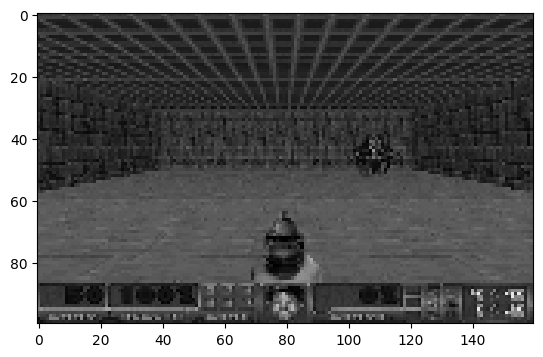

In [16]:
# showing model, checking if it is set up correct
env = VizDoomGym(render=False)
state = env.reset()
plt.imshow(cv2.cvtColor(state, cv2.COLOR_BGR2RGB))

# checks
# env_checker.check_env(env)

env.close()

# Training the model!

PPO Model design. Wiki: https://en.wikipedia.org/wiki/Proximal_policy_optimization

In [17]:
import os
from stable_baselines3.common.callbacks import BaseCallback

In [18]:
# for logging and saving models
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [19]:
CHECKPOINT_DIR = "./train/model_basic_1"
LOG_DIR = "./train/logs_basic_1"

# save model every 10,000 steps
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

# Training

In [3]:
from stable_baselines3 import PPO

In [58]:
# creating the model

env = VizDoomGym(render=False)

In [59]:
model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.0001, n_steps=2048)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


/Users/shaanyadav/opt/anaconda3/envs/sandbox-experiments/lib/python3.9/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [60]:
model.learn(total_timesteps=100000, callback=callback)

Logging to ./train/logs_basic_1/PPO_6
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 35.3     |
|    ep_rew_mean     | -98.1    |
| time/              |          |
|    fps             | 302      |
|    iterations      | 1        |
|    time_elapsed    | 6        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 40.8        |
|    ep_rew_mean          | -131        |
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 2           |
|    time_elapsed         | 35          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009680945 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | -0.000

# Eval


In [25]:

from stable_baselines3.common.evaluation import evaluate_policy

In [26]:
# Reload model from disc
model = PPO.load('./train/model_basic_1/best_model_100000')

In [27]:
# Create rendered environment
env = VizDoomGym(render=True)

In [28]:
# Evaluate mean reward for 10 games
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=100)
mean_reward

81.4

In [29]:
for episode in range(100): 
    obs = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        time.sleep(0.25)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode,total_reward))
    time.sleep(2)

Total Reward for episode 0 is 95.0
Total Reward for episode 1 is 87.0
Total Reward for episode 2 is 71.0
Total Reward for episode 3 is 79.0
Total Reward for episode 4 is 75.0
Total Reward for episode 5 is 75.0
Total Reward for episode 6 is 75.0
Total Reward for episode 7 is 71.0
Total Reward for episode 8 is 83.0
Total Reward for episode 9 is 83.0
Total Reward for episode 10 is 67.0
Total Reward for episode 11 is 63.0
Total Reward for episode 12 is 87.0
Total Reward for episode 13 is 75.0
Total Reward for episode 14 is 95.0


ViZDoomUnexpectedExitException: Controlled ViZDoom instance exited unexpectedly.